## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?

#### Ответы
* Методы User-User и Item-Item одинаковы по своей логике. В User-User находятся похожие пользователи, и рекомендации для пользователя строятся по усредненным предпочтениям его соседей. В Item-Item находятся похожие товары, и рекомендации для пользователя строятся по товарам, похожим на его предпочтения. Оба метода похожи тем, что им обоим требуется нормализация данных. Например, есть пользователи, которые почти всегда ставят положительные оценки, и их отрицательные оценки будут более информативны (или, наоборот, положительные оценки от хейтеров более информативны). Также оба метода имеют одинаковые способы нахождения близости объектов, например, через косинусные расстояния.
* Различия. Методы item-item чаще практически более применимы, так как пользователей обычно на один или даже несколько порядков больше, чем items. Соответственно, в user-user алгоритм на порядки сложнее. Таким образом, в user-user расстояний между объектами очень много и они не очень точные, а в item-item наоборот. Так же предпочтения пользователей могут меняться со временем, а характеристики схожих товаров постоянны - это плюс алгоритму item-item/

* Хоть алгоритмы item_item и user-user похожи по сути, но по структуре разные. Функции нельзя использовать функции одного алгоритма в другом.

* алгоритм item-item учитывает схожесть товаров, а ALS учитывает как и латентные факторы предпочтений пользователей, так и латентные факторы характеристик товаров.

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 

### Ответ
* наличие отзыва пользователя на товар
* оценка пользователя на товар
* наличие скидки на товар
* средняя скидка на товар (сумма скидок всех покупок конкретного товара конкретным пользователем деленная на количество покупок этого товара этим пользователем)
* факт того, что товар купленный однажды по скидке, повторно куплен без скидки (мне кажется повторная покупка товара без скидки отражает предпочтение пользователя товару)

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)

Тип информации - числовая


4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

## Практическая часть


In [1]:
import implicit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [4]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [6]:
test_result = data_test.groupby('user_id')['item_id'].unique().reset_index()
test_result.columns=['user_id', 'actual']
test_result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [7]:
train_result = data_train.groupby('user_id')['item_id'].unique().reset_index()
train_result.columns=['user_id', 'actual']
train_result.head(2)

,user_id,actual
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."


### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.

### Коэффициенты - суммарная стоимость покупок

In [8]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [9]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', # Можно пробоват ьдругие варианты
                                  aggfunc='sum', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

c:\users\aech\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [11]:
csr_mat = csr_matrix(user_item_matrix).T.tocsr()

In [12]:
%%time

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)


Wall time: 8.82 s


In [13]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

#### ТОЧНОСТЬ На трейне

In [14]:
%%time
    
train_result['als'] = train_result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
train_result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

Wall time: 35.7 s


0.5912765106042417

#### ТОЧНОСТЬ На тесте

In [15]:
%%time
    
test_result['als'] = test_result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
test_result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

Wall time: 32.6 s


0.10078354554358471

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.GridSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!

In [16]:
import time

In [19]:
hyp_result={
    'lambda':[],
    'n_factors':[],
    'fit_time':[],
    'precis_on_train':[],
    'precis_on_test':[]
}


first_time = time.time()
i=0
for lmbda in [0.0001, 0.001, 0.01, 0.1]:
    for n_factors in [10, 50, 100, 150, 300]:
        
        hyp_result['lambda'].append(lmbda)
        hyp_result['n_factors'].append(n_factors)

        start_time = time.time()
        model = AlternatingLeastSquares(factors=n_factors, #k
                                regularization=lmbda,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)        
        model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=False)
        end_time = time.time()
        
        hyp_result['fit_time'].append(end_time-start_time)
        
        res_name = f'als: lambda {lmbda}, n_factors: {n_factors}'
        train_result[res_name] = train_result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        precis_on_train = train_result.apply(lambda row: precision_at_k(row[res_name], row['actual']), axis=1).mean()
        hyp_result['precis_on_train'].append(precis_on_train)

        test_result[res_name] = test_result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        precis_on_test = test_result.apply(lambda row: precision_at_k(row[res_name], row['actual']), axis=1).mean()
        hyp_result['precis_on_test'].append(precis_on_test)
        
        cycle_time = time.time()
        i+=1
        print(f'Цикл {i} из 20, времени прошло {(cycle_time-first_time):.2f}')



Цикл 1 из 20, времени прошло 22.57
Цикл 2 из 20, времени прошло 67.07
Цикл 3 из 20, времени прошло 147.70
Цикл 4 из 20, времени прошло 267.76
Цикл 5 из 20, времени прошло 549.91
Цикл 6 из 20, времени прошло 574.99
Цикл 7 из 20, времени прошло 621.41
Цикл 8 из 20, времени прошло 696.03
Цикл 9 из 20, времени прошло 827.23
Цикл 10 из 20, времени прошло 1108.50
Цикл 11 из 20, времени прошло 1133.44
Цикл 12 из 20, времени прошло 1191.31
Цикл 13 из 20, времени прошло 1266.29
Цикл 14 из 20, времени прошло 1388.13
Цикл 15 из 20, времени прошло 1677.70
Цикл 16 из 20, времени прошло 1703.06
Цикл 17 из 20, времени прошло 1750.16
Цикл 18 из 20, времени прошло 1838.81
Цикл 19 из 20, времени прошло 1961.44
Цикл 20 из 20, времени прошло 2252.54


AttributeError: module 'pandas' has no attribute 'DateFarme'

глупая ошибка, но ничего страшного, все сохранилось :)))

In [21]:
hyper_result = pd.DataFrame(hyp_result)

Результат:

In [22]:
hyper_result

,lambda,n_factors,fit_time,precis_on_train,precis_on_test
0,0.0001,10,3.760943,0.471389,0.130754
1,0.0001,50,8.505260,0.510124,0.103232
2,0.0001,100,9.166493,0.594878,0.095984
3,0.0001,150,11.129628,0.693397,0.102253
4,0.0001,300,13.718323,0.863385,0.098433
5,0.0010,10,4.816123,0.463786,0.128306
6,0.0010,50,9.558444,0.509004,0.102351
7,0.0010,100,9.396828,0.590636,0.102938
8,0.0010,150,11.869264,0.692357,0.106464
9,0.0010,300,13.673407,0.860584,0.098923


# ГРАФИКИ


In [23]:
from matplotlib import pyplot as plt

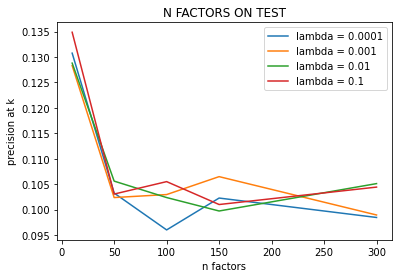

In [46]:
plt.plot([10, 50, 100, 150, 300],hyper_result.loc[hyper_result['lambda']==0.0001,'precis_on_test'], label = 'lambda = 0.0001')
plt.plot([10, 50, 100, 150, 300],hyper_result.loc[hyper_result['lambda']==0.001,'precis_on_test'], label = 'lambda = 0.001')
plt.plot([10, 50, 100, 150, 300],hyper_result.loc[hyper_result['lambda']==0.01,'precis_on_test'], label = 'lambda = 0.01')
plt.plot([10, 50, 100, 150, 300],hyper_result.loc[hyper_result['lambda']==0.1,'precis_on_test'], label = 'lambda = 0.1')
plt.legend()
plt.xlabel('n factors')
plt.ylabel('precision at k')
plt.title('N FACTORS ON TEST')
plt.show()

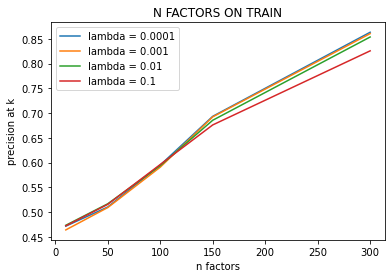

In [48]:
plt.plot([10, 50, 100, 150, 300],hyper_result.loc[hyper_result['lambda']==0.0001,'precis_on_train'], label = 'lambda = 0.0001')
plt.plot([10, 50, 100, 150, 300],hyper_result.loc[hyper_result['lambda']==0.001,'precis_on_train'], label = 'lambda = 0.001')
plt.plot([10, 50, 100, 150, 300],hyper_result.loc[hyper_result['lambda']==0.01,'precis_on_train'], label = 'lambda = 0.01')
plt.plot([10, 50, 100, 150, 300],hyper_result.loc[hyper_result['lambda']==0.1,'precis_on_train'], label = 'lambda = 0.1')
plt.legend()
plt.xlabel('n factors')
plt.ylabel('precision at k')
plt.title('N FACTORS ON TRAIN')
plt.show()

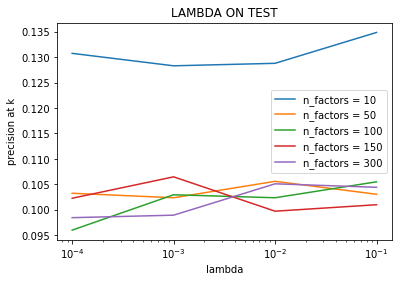

In [44]:
plt.plot([0.0001, 0.001, 0.01, 0.1],hyper_result.loc[hyper_result['n_factors']==10 ,'precis_on_test'], label = 'n_factors = 10')
plt.plot([0.0001, 0.001, 0.01, 0.1],hyper_result.loc[hyper_result['n_factors']==50 ,'precis_on_test'], label = 'n_factors = 50')
plt.plot([0.0001, 0.001, 0.01, 0.1],hyper_result.loc[hyper_result['n_factors']==100,'precis_on_test'], label = 'n_factors = 100')
plt.plot([0.0001, 0.001, 0.01, 0.1],hyper_result.loc[hyper_result['n_factors']==150,'precis_on_test'], label = 'n_factors = 150')
plt.plot([0.0001, 0.001, 0.01, 0.1],hyper_result.loc[hyper_result['n_factors']==300,'precis_on_test'], label = 'n_factors = 300')
plt.xscale('log')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('precision at k')
plt.title('LAMBDA ON TEST')
plt.show()

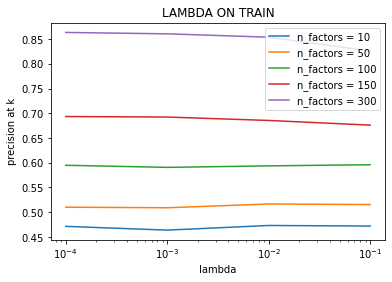

In [45]:
plt.plot([0.0001, 0.001, 0.01, 0.1],hyper_result.loc[hyper_result['n_factors']==10 ,'precis_on_train'], label = 'n_factors = 10')
plt.plot([0.0001, 0.001, 0.01, 0.1],hyper_result.loc[hyper_result['n_factors']==50 ,'precis_on_train'], label = 'n_factors = 50')
plt.plot([0.0001, 0.001, 0.01, 0.1],hyper_result.loc[hyper_result['n_factors']==100,'precis_on_train'], label = 'n_factors = 100')
plt.plot([0.0001, 0.001, 0.01, 0.1],hyper_result.loc[hyper_result['n_factors']==150,'precis_on_train'], label = 'n_factors = 150')
plt.plot([0.0001, 0.001, 0.01, 0.1],hyper_result.loc[hyper_result['n_factors']==300,'precis_on_train'], label = 'n_factors = 300')
plt.xscale('log')

plt.legend()
plt.xlabel('lambda')
plt.ylabel('precision at k')
plt.title('LAMBDA ON TRAIN')
plt.show()

* Наилучшие результаты на тесте при n_factors = 10
* Результаты на тесте при дугих n_factors не сильно отличаются, но заметно проседание точности на тесте n_factors. 
* Так же заметен стабильный рост точности при увеличении n_factors.
* Это вызвано эффектом переобучения. Большое количество латентных факторов позволет максимально точно настроиться под каждый Item и user на трейне, как следствие пропадает обощающая способность. При n_factors = 10 обобщающая способность высокая, (так как мало факторов - легче обобщить), что дает наилучший результат на тесте, и, закономерно, наименьший на трейне.

* лямбда на трейне вобще не играет роли
* лямбда на тесете как-то странно себя ведет, дл боле точного анализа требуется больше итераций fit-predict и оценка усредненная оценка влияния регулризации на точность. 
* при n = 10 повыешние регуляризации привело к улучшению результата, такой же эффект видено при n 100 и 300
* по времени график не строил, но итак по таблице видно и очевидно, что при увеличении n_factors врем обучения растет